<center>

## User Experience Analysis
</center> 

#### Import Libraries and Load the Dataset

In [1]:
import os
import sys
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Get the current working directory
current_dir = os.getcwd()

# Append the parent directory to sys.path
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)


# ignore warrnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# import Postgres connection from DB_connection folder
from DB_connection.connection import PostgresConnection

In [3]:
# Create an instance of the PostgresConnection class and connect to the database
db=PostgresConnection()
db.connect()

Connected to PostgreSQL database


In [4]:
# query to retrive all the data from xdr_data table
query='select * from xdr_data'
db.execute_query(query)

Query executed successfully


In [5]:
# Assign the data to a dataframe named 'df'
df=db.fetch_data(query)
df.head()

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,1.311448e+19,4/4/2019 12:01,770.0,4/25/2019 14:35,662.0,1823652.0,2.082014e+14,3.366496e+10,3.552121e+13,9.16456699548519E+015,...,15854611.0,2501332.0,8198936.0,9656251.0,278082303.0,14344150.0,171744450.0,8814393.0,36749741.0,308879636.0
1,1.311448e+19,4/9/2019 13:04,235.0,4/25/2019 8:15,606.0,1365104.0,2.082019e+14,3.368185e+10,3.579401e+13,L77566A,...,20247395.0,19111729.0,18338413.0,17227132.0,608750074.0,1170709.0,526904238.0,15055145.0,53800391.0,653384965.0
2,1.311448e+19,4/9/2019 17:42,1.0,4/25/2019 11:58,652.0,1361762.0,2.082003e+14,3.376063e+10,3.528151e+13,D42335A,...,19725661.0,14699576.0,17587794.0,6163408.0,229584621.0,395630.0,410692588.0,4215763.0,27883638.0,279807335.0
3,1.311448e+19,4/10/2019 0:31,486.0,4/25/2019 7:36,171.0,1321509.0,2.082014e+14,3.375034e+10,3.535661e+13,T21824A,...,21388122.0,15146643.0,13994646.0,1097942.0,799538153.0,10849722.0,749039933.0,12797283.0,43324218.0,846028530.0
4,1.311448e+19,4/12/2019 20:10,565.0,4/25/2019 10:40,954.0,1089009.0,2.082014e+14,3.369980e+10,3.540701e+13,D88865A,...,15259380.0,18962873.0,17124581.0,415218.0,527707248.0,3529801.0,550709500.0,13910322.0,38542814.0,569138589.0


#### Aggregate Per Customer Information

- Handle Missing Values and Outliers: Replace missing values and outliers with the mean or mode.
- Aggregate Average Metrics Per Customer

In [16]:
# Replace missing values with mean for numerical columns and mode for categorical columns
df['Avg RTT DL (ms)'].fillna(df['Avg RTT DL (ms)'].mean(), inplace=True)
df['Avg RTT UL (ms)'].fillna(df['Avg RTT UL (ms)'].mean(), inplace=True)
df['Avg Bearer TP DL (kbps)'].fillna(df['Avg Bearer TP DL (kbps)'].mean(), inplace=True)
df['Avg Bearer TP UL (kbps)'].fillna(df['Avg Bearer TP UL (kbps)'].mean(), inplace=True)
df['TCP DL Retrans. Vol (Bytes)'].fillna(df['TCP DL Retrans. Vol (Bytes)'].mean(), inplace=True)
df['TCP UL Retrans. Vol (Bytes)'].fillna(df['TCP UL Retrans. Vol (Bytes)'].mean(), inplace=True)
df['Handset Type'].fillna(df['Handset Type'].mode()[0], inplace=True)

# Aggregating the required information per customer (MSISDN/Number)
aggregated_df = df.groupby('MSISDN/Number').agg({
    'TCP DL Retrans. Vol (Bytes)': 'mean',
    'TCP UL Retrans. Vol (Bytes)': 'mean',
    'Avg RTT DL (ms)': 'mean',
    'Avg RTT UL (ms)': 'mean',
    'Avg Bearer TP DL (kbps)': 'mean',
    'Avg Bearer TP UL (kbps)': 'mean',
    'Handset Type': 'first'  # Taking the first handset type per customer
}).reset_index()

# Renaming the columns for better readability
aggregated_df.columns = [
    'Customer Number', 'Avg TCP DL Retransmission', 'Avg TCP UL Retransmission',
    'Avg RTT DL', 'Avg RTT UL', 'Avg Throughput DL', 'Avg Throughput UL', 'Handset Type'
]

aggregated_df.head()



,Customer Number,Avg TCP DL Retransmission,Avg TCP UL Retransmission,Avg RTT DL,Avg RTT UL,Avg Throughput DL,Avg Throughput UL,Handset Type
0,3.360100e+10,2.080991e+07,759658.664811,46.000000,0.000000,37.0,39.0,Huawei P20 Lite Huawei Nova 3E
1,3.360100e+10,2.080991e+07,759658.664811,30.000000,1.000000,48.0,51.0,Apple iPhone 7 (A1778)
2,3.360100e+10,2.080991e+07,759658.664811,109.795706,17.662883,48.0,49.0,undefined
3,3.360101e+10,1.066000e+03,759658.664811,69.000000,15.000000,204.0,44.0,Apple iPhone 5S (A1457)
4,3.360101e+10,1.507977e+07,390430.332406,57.000000,2.500000,20197.5,8224.5,Apple iPhone Se (A1723)


#### Compute Top, Bottom, and Most Frequent Values

In [12]:
# Top 10 TCP values
top10_tcp_dl = df['TCP DL Retrans. Vol (Bytes)'].nlargest(10)
bottom10_tcp_dl = df['TCP DL Retrans. Vol (Bytes)'].nsmallest(10)
most_freq_tcp_dl = df['TCP DL Retrans. Vol (Bytes)'].value_counts().nlargest(10)

# Repeat the above for RTT and Throughput
top10_rtt_dl = df['Avg RTT DL (ms)'].nlargest(10)
bottom10_rtt_dl = df['Avg RTT DL (ms)'].nsmallest(10)
most_freq_rtt_dl = df['Avg RTT DL (ms)'].value_counts().nlargest(10)

# Top 10 Throughput values
top10_throughput_dl = df['Avg Bearer TP DL (kbps)'].nlargest(10)
bottom10_throughput_dl = df['Avg Bearer TP DL (kbps)'].nsmallest(10)
most_freq_throughput_dl = df['Avg Bearer TP DL (kbps)'].value_counts().nlargest(10)

print("Top 10 TCP DL Retransmission values:\n", top10_tcp_dl)
print("\n Bottom 10 TCP DL Retransmission values:\n", bottom10_tcp_dl)
print("\n Most Frequent TCP DL Retransmission values:\n", most_freq_tcp_dl)

Top 10 TCP DL Retransmission values:
 77979     4.294426e+09
135678    4.291380e+09
34645     4.289877e+09
140813    4.289488e+09
3782      4.288060e+09
119684    4.275259e+09
39637     4.268432e+09
76990     4.259997e+09
59016     4.256650e+09
41209     4.254644e+09
Name: TCP DL Retrans. Vol (Bytes), dtype: float64

 Bottom 10 TCP DL Retransmission values:
 59717     2.0
125094    2.0
2850      4.0
39610     4.0
52488     4.0
60376     4.0
60426     4.0
75093     4.0
100314    4.0
143429    4.0
Name: TCP DL Retrans. Vol (Bytes), dtype: float64

 Most Frequent TCP DL Retransmission values:
 TCP DL Retrans. Vol (Bytes)
2.080991e+07    88146
1.330000e+03      433
2.660000e+03      219
3.800000e+01      200
9.200000e+01      192
1.318000e+03      156
5.430000e+02      133
3.990000e+03      114
7.600000e+01      108
5.320000e+03      102
Name: count, dtype: int64


#### Distribution Analysis

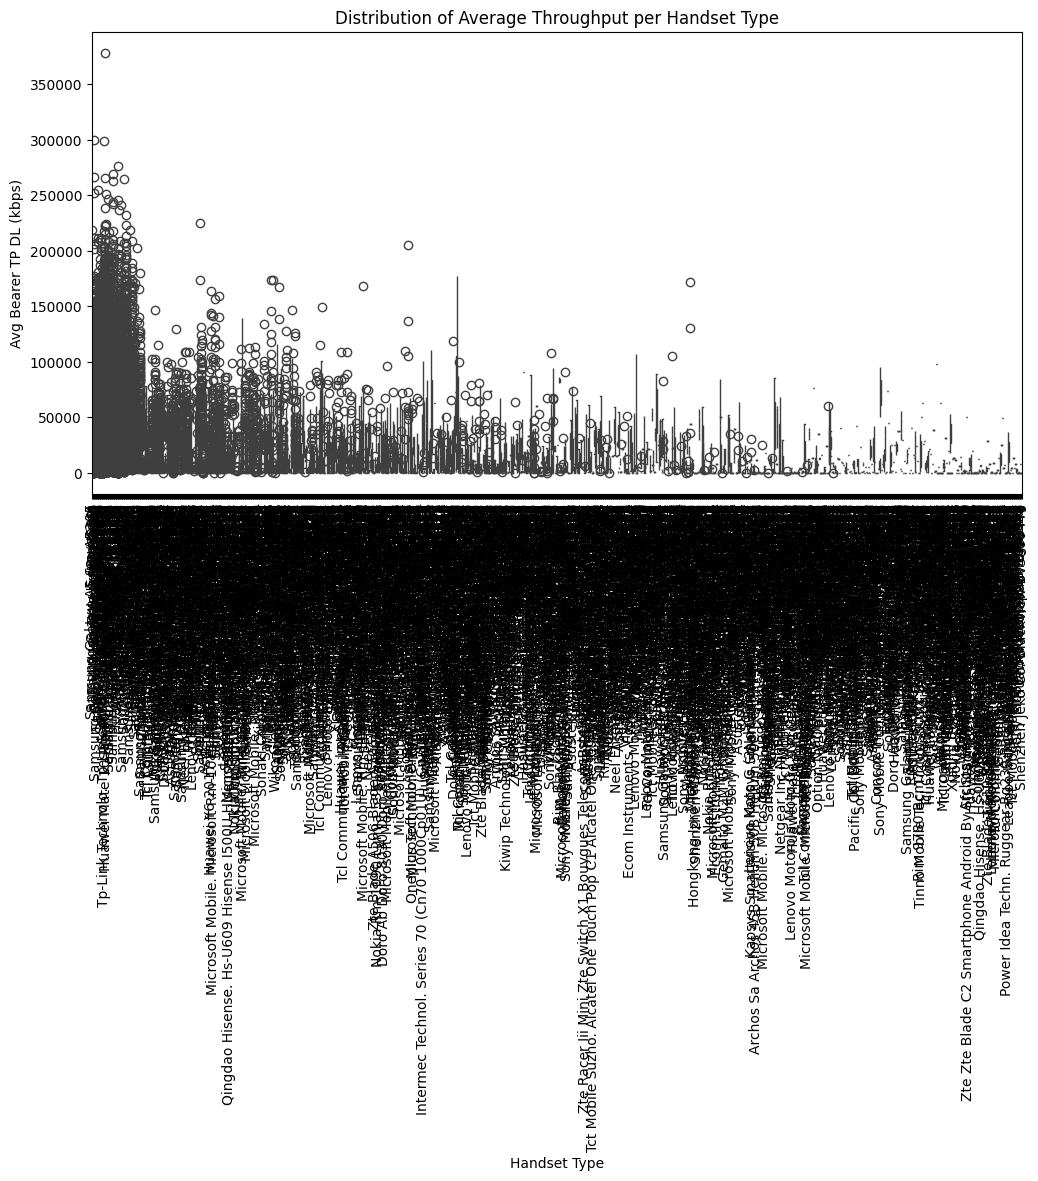

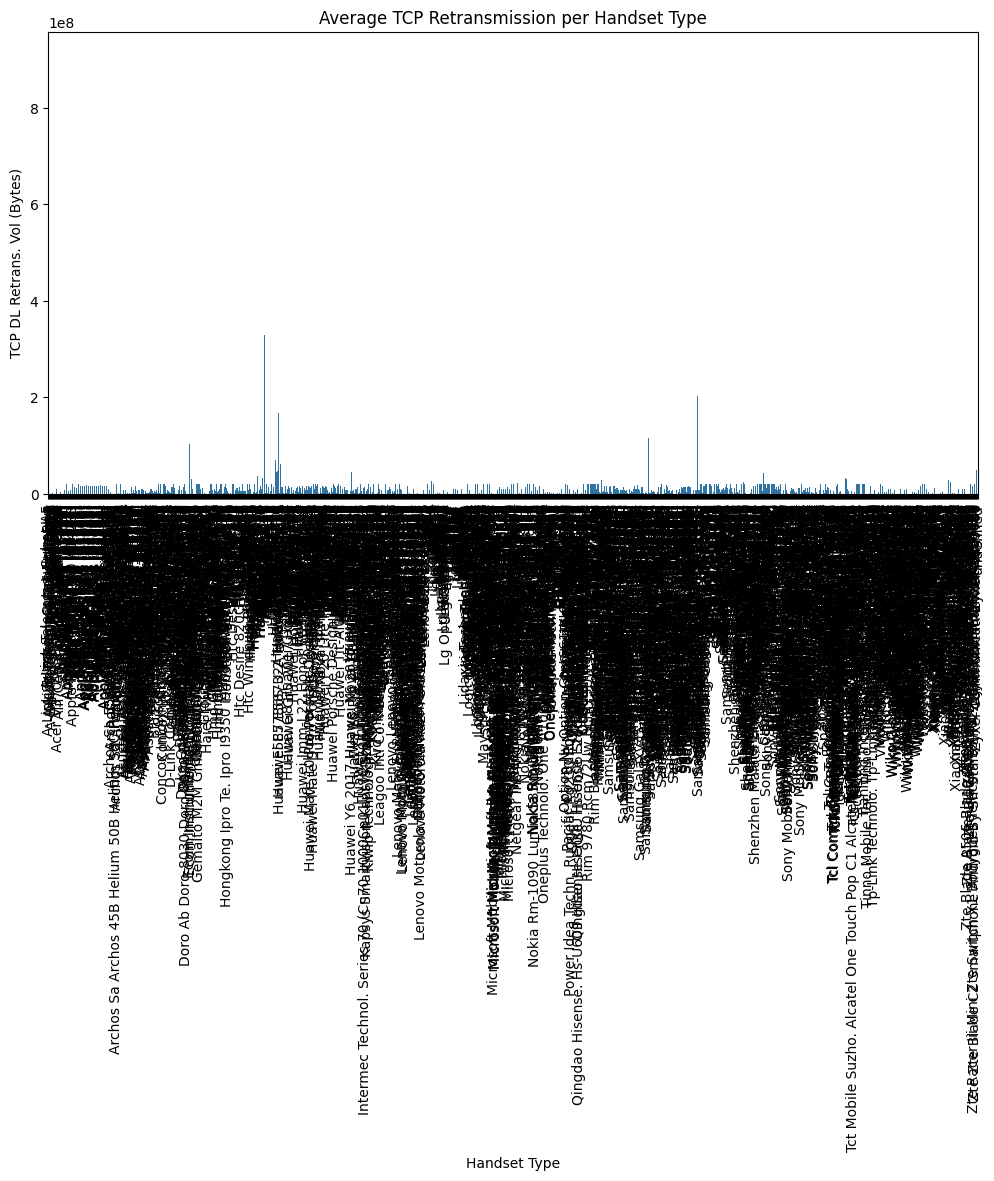

In [13]:
# Distribution of average throughput per handset type
plt.figure(figsize=(12, 6))
sns.boxplot(x='Handset Type', y='Avg Bearer TP DL (kbps)', data=df)
plt.xticks(rotation=90)
plt.title('Distribution of Average Throughput per Handset Type')
plt.show()

# Average TCP retransmission per handset type
avg_tcp_retrans_per_handset = df.groupby('Handset Type')['TCP DL Retrans. Vol (Bytes)'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='Handset Type', y='TCP DL Retrans. Vol (Bytes)', data=avg_tcp_retrans_per_handset)
plt.xticks(rotation=90)
plt.title('Average TCP Retransmission per Handset Type')
plt.show()

#### K-Means Clustering to group customers based on their experience metrics
- ***K*** = 3

In [18]:
# Selecting relevant columns for clustering
features = aggregated_df[['Avg TCP DL Retransmission', 'Avg RTT DL', 'Avg Throughput DL']]

# Normalizing the data
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

# Applying K-Means clustering with k=3
kmeans = KMeans(n_clusters=3, random_state=42)
aggregated_df['Experience Cluster'] = kmeans.fit_predict(features_scaled)

# Select only numeric columns for the cluster description
numeric_columns = aggregated_df.select_dtypes(include=[np.number]).columns

# Describing each cluster
cluster_description = aggregated_df.groupby('Experience Cluster')[numeric_columns].mean()

cluster_description

,Customer Number,Avg TCP DL Retransmission,Avg TCP UL Retransmission,Avg RTT DL,Avg RTT UL,Avg Throughput DL,Avg Throughput UL,Experience Cluster
Experience Cluster,,,,,,,,
0,3.367832e+10,7.547280e+07,1.894629e+06,68.198253,25.659841,75788.913818,8090.130257,0.0
1,4.898971e+10,1.702167e+07,6.729773e+05,128.753841,14.701205,1908.707988,378.642024,1.0
2,3.367700e+10,1.716309e+07,6.675958e+05,90.798795,22.266177,31086.944537,4047.730840,2.0
